# Final project: Identification of vulnerable population groups

## 1. Problem statement

According to a December 2021 [inFOM survey](https://www.cbr.ru/Collection/Collection/File/39633/inFOM_21-12.pdf), 27% of Russians have enough money only for food, and another 9% cannot afford a nutritious diet. These people are especially attentive to prices, and the rate of growth of food prices usually exceeds the average rate of inflation. At the same time, Rosstat believes that food expenses should make up approximately 36% of a Russian's average monthly expenses (another 10% goes to utilities and housing, 4% goes to medicines). 

Until 2021, the "poverty line" (living below the subsistence minimum) in Russia was determined by the cost of the [minimum food basket](https://base.garant.ru/70306880/). In the same year, the government "untied" the poverty level from the prices of basic products: since 2021, the subsistence minimum is calculated as 44.2% of the median income of Russian citizens for the previous year.

You have at your disposal data on income, morbidity, socially vulnerable groups of the Russian population and other economic and demographic data.

Your task as a data scientist:
* cluster the regions of Russia and determine which of them are in the greatest need of assistance to low-income/disadvantaged segments of the population;
* describe the population groups facing poverty;
* determine:
    * whether the number of children, pensioners and other socially vulnerable groups affects the poverty level in the region;
    * whether the level of poverty/social disadvantage is related to production and consumption in the region;
    * what other dependencies can be observed in relation to socially vulnerable segments of the population.

## 2. Getting to know the data

To reduce data redundancy, data for districts uniting multiple regions has been removed from the initial data sources. Also the following former regions have been removed, since they have significant amount of empty values: 
* Агинский Бурятский округ (Забайкальский край)
* Коми-Пермяцкий округ, входящий в состав Пермского края
* Корякский округ, входящий в состав Камчатского края
* Таймырский (Долгано-Ненецкий) автономный округ (Красноярский край)
* Усть-Ордынский Бурятский округ
* Эвенкийский автономный округ (Красноярский край)

### 2.0 Import dependencies and define helper code

#### 2.0.1 Import dependencies

In [721]:
import pandas as pd
import plotly.express as px

from scipy import stats

#### 2.0.2 Define helper code

In [722]:
regions_count = 85


def drop_empty_years(df):
    missing = df.isnull().sum()
    missing_columns = missing[missing > regions_count * 0.6].index
    df = df.drop(missing_columns, axis=1)
    return df


def normalize_data(df):
    return df.apply(
        stats.zscore, 
        axis=1, 
        nan_policy='omit'
    )


def rename_columns(df, prefix, start_col=1):
    dict_columns = {}
    for i in range(start_col, df.shape[1]):
        dict_columns[df.columns[i]] = prefix + str(df.columns[i])

    return df.rename(columns=dict_columns)

### 2.1 Population data

Data source contains the population dynamics of the Russian regions across the years 1999 and 2022. Columns:
1. `region` - name of the region of the Russian Federation. 
2. `population_1999-population_2022` - columns containing the population count for each of the regions in the corresponding year.

In [723]:
data_population = pd.read_excel('data/population.xlsx', 'report')
for i in range(data_population.shape[0]//2):
    data_population.iloc[i, 1:] = data_population.iloc[i+1, 1:]
    data_population.drop(index=i+1, inplace=True)
    data_population = data_population.reset_index(drop=True)

data_population = data_population.set_index('region')
data_population = data_population.sort_index()

Let's visualize the population dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

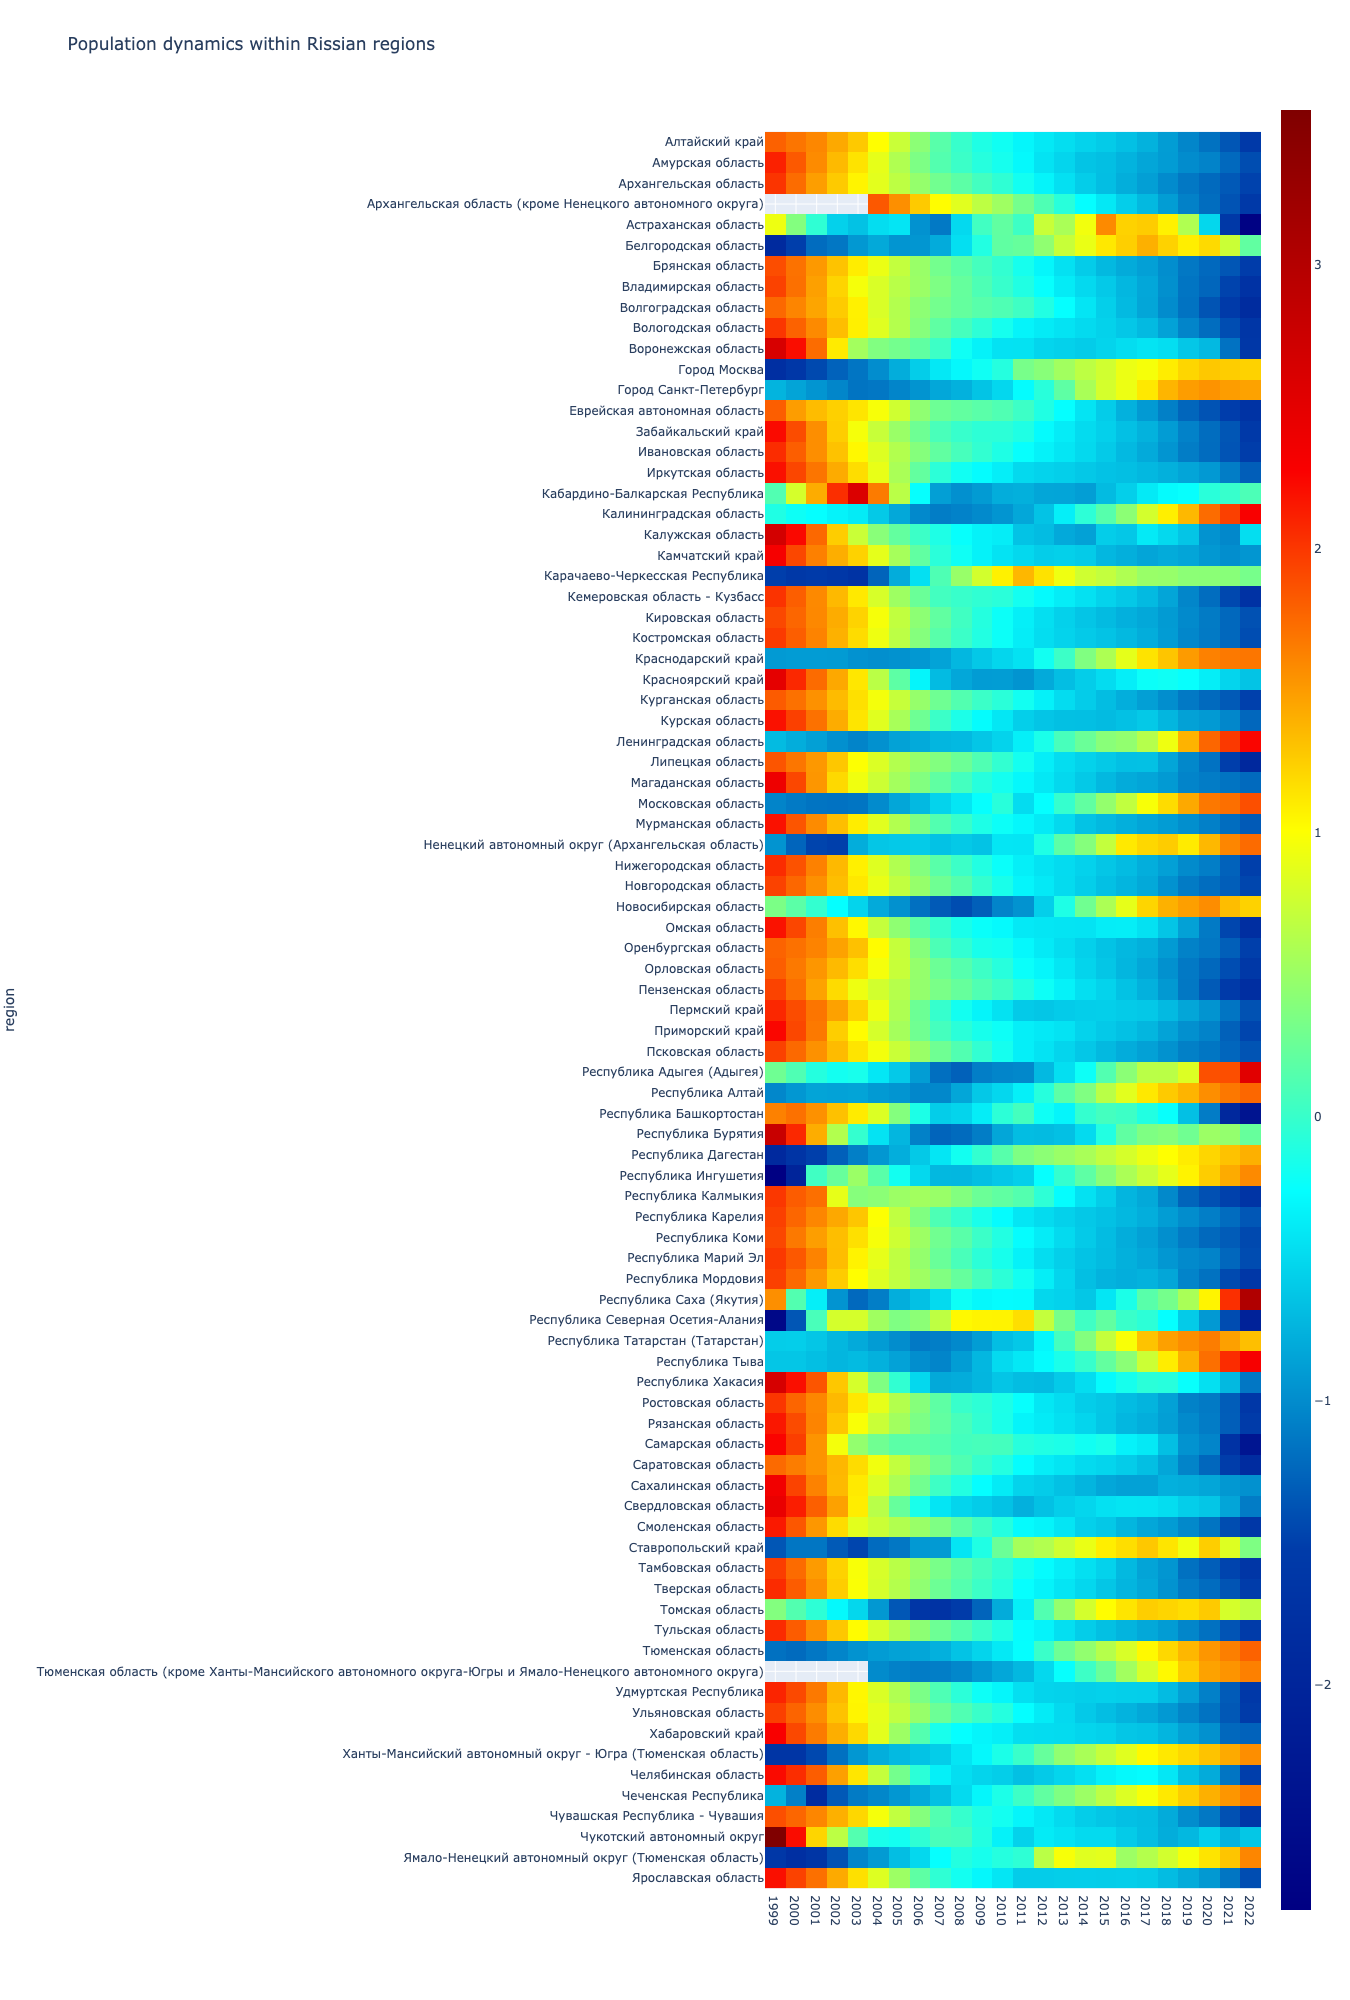

In [724]:
data_population_normalized = normalize_data(data_population)

fig = px.imshow(
    data_population_normalized,
    height=2000,
    width=1350,
    color_continuous_scale='Jet',
    title='Population dynamics within Rissian regions'
)
fig.show('png')

We observe that there are more regions with the population decline than regions with the population growth. If we connect population decline with the economic situation of the region, we will probably observe a larger amount of the regions in the cluster with economic issues.

### 2.2 Child mortality in rural areas

Data source contains child mortality in rural areas on the first life year in persons per Russian region across the years 1990 and 2021 in absolute values. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `child_mortality_rural_1990-child_mortality_rural_2021` - columns containing the child mortality in rural areas for each of the regions in the corresponding year.

In [725]:
data_child_mortality_rural = pd.read_excel('data/child_mortality_rural_1990_2021.xlsx')
data_child_mortality_rural['region'] = data_child_mortality_rural['region'].str.strip()
data_child_mortality_rural = data_child_mortality_rural.set_index('region', drop=True)
data_child_mortality_rural = data_child_mortality_rural.sort_index()

Let's visualize the child mortality in rural areas dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

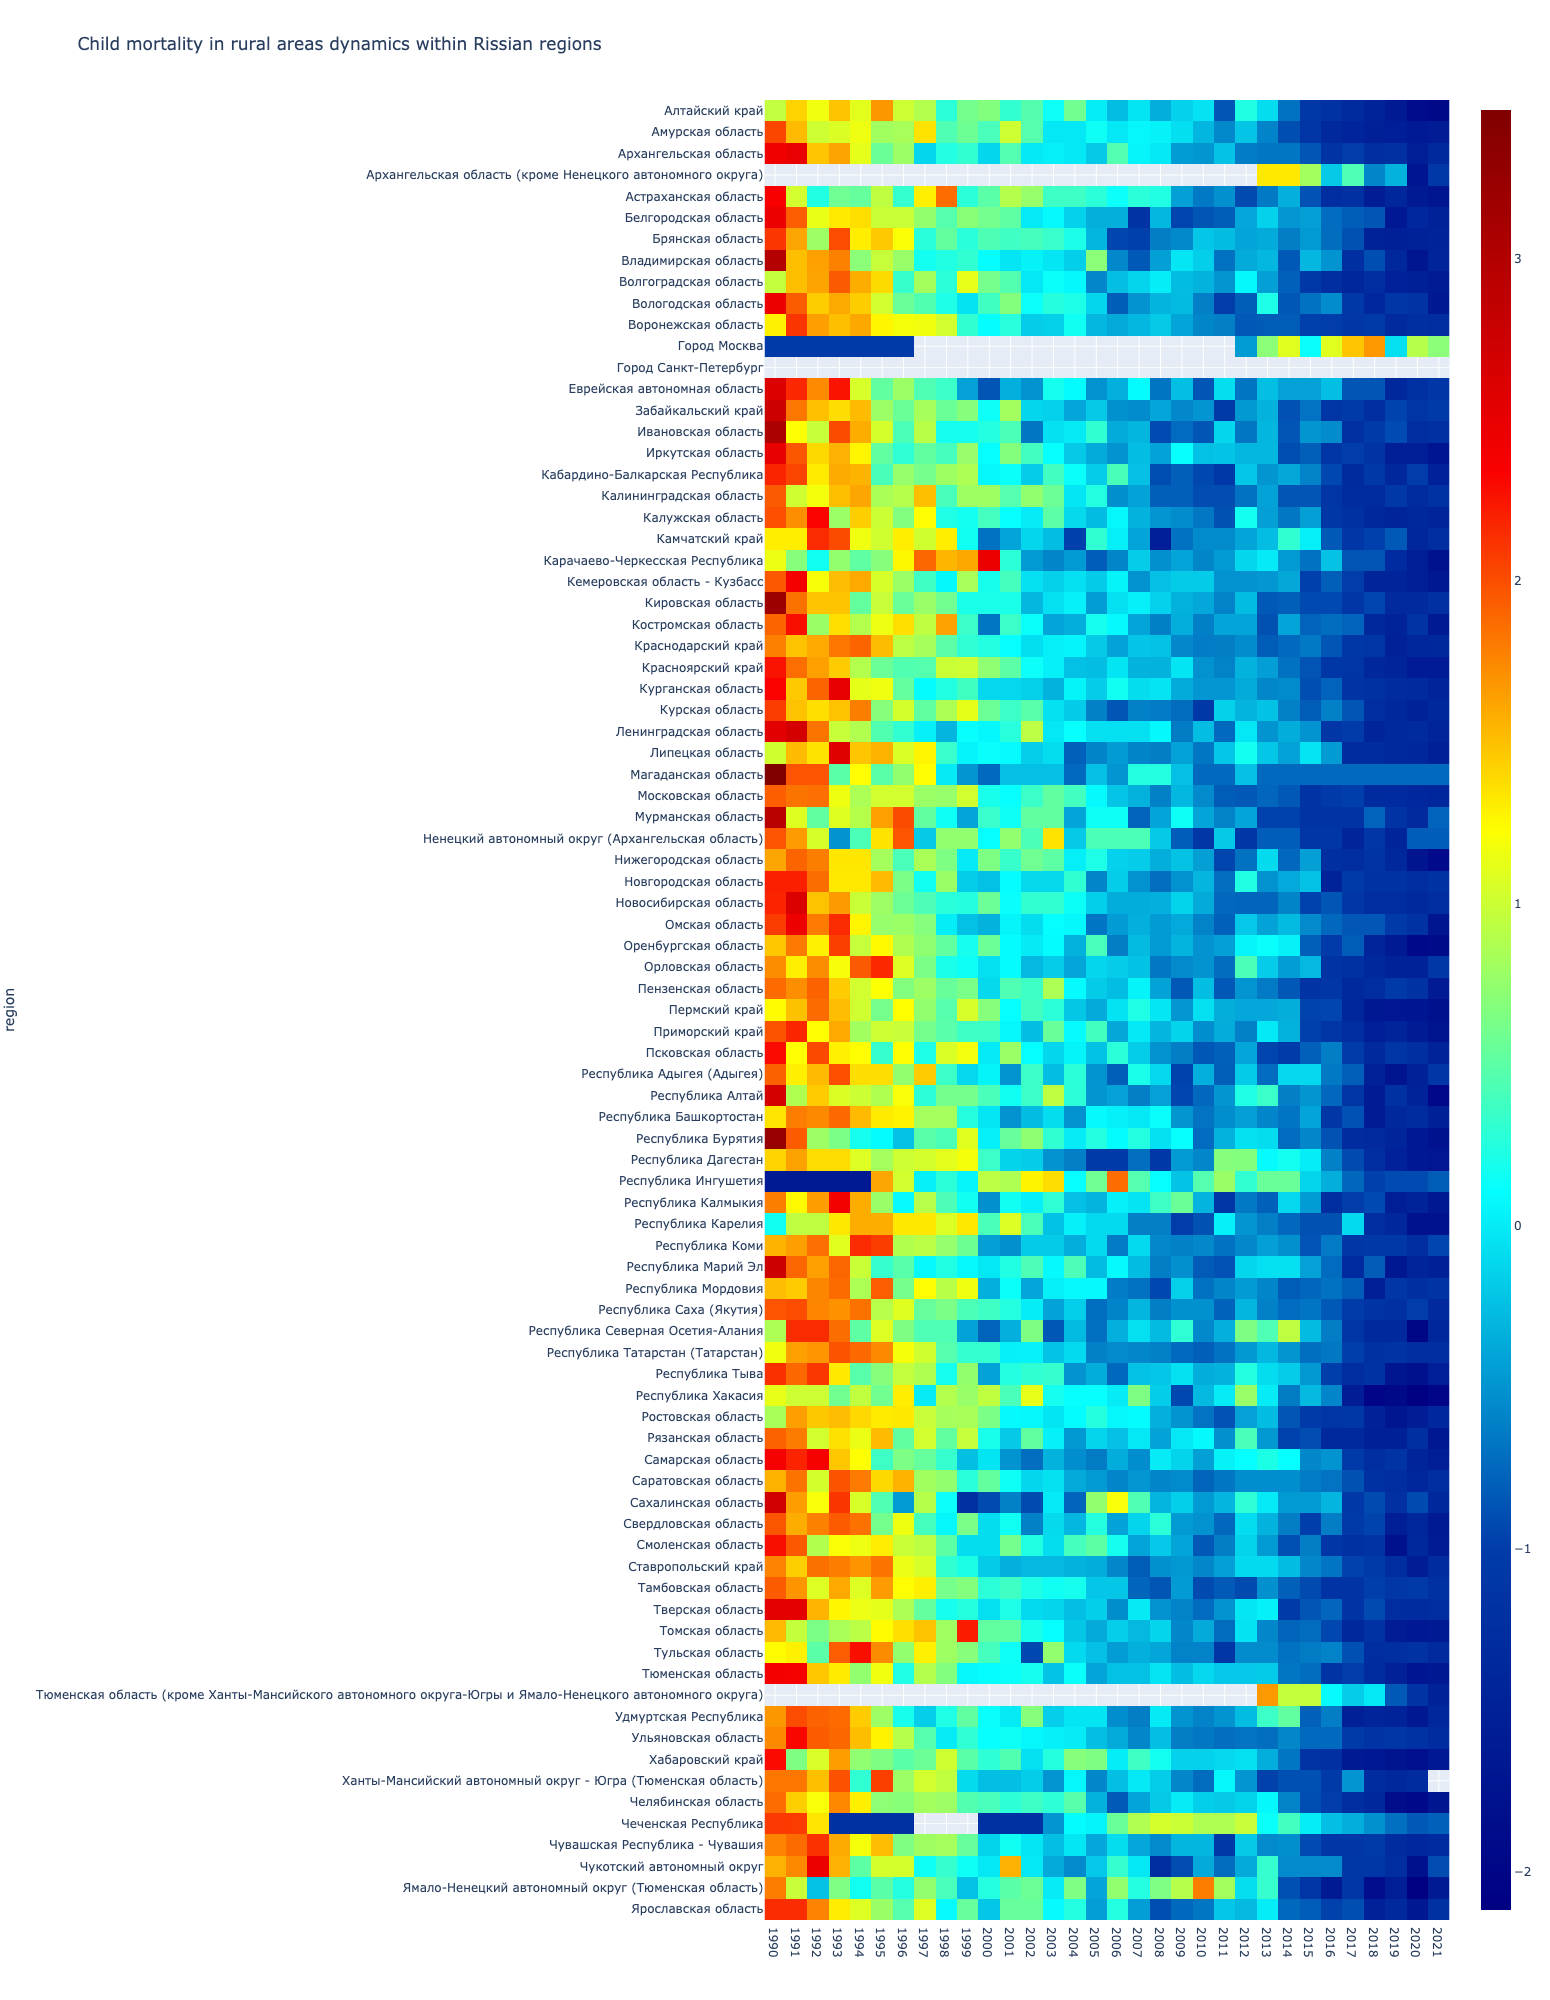

In [726]:
data_child_mortality_rural_normalized = normalize_data(data_child_mortality_rural)

fig = px.imshow(
    data_child_mortality_rural_normalized,
    height=2000,
    width=1550,
    color_continuous_scale='Jet',
    title='Child mortality in rural areas dynamics within Rissian regions'
)
fig.show('png')

Child mortality in rural areas has significantly decreased with the exception of the following regions:
- Город Москва
- Магаданская область
- Республика Ингушетия
- Чеченская Республика

If we connect the child mortality with the economic situation of the region, we cann assume that after applying the cluster algorithms these regions might be in the cluster of economically weaker regions. Which is definitely not the case for the city of Moscow.

### 2.3 Child mortality in urban areas

Data source contains child mortality in urban areas on the first life year in persons per Russian region across the years 1990 and 2021 in absolute values. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `child_mortality_urban_1990-child_mortality_urban_2021` - columns containing the child mortality in urban areas for each of the regions in the corresponding year.

In [727]:
data_child_mortality_urban = pd.read_excel('data/child_mortality_urban_1990_2021.xlsx')
data_child_mortality_urban['region'] = data_child_mortality_urban['region'].str.strip()
data_child_mortality_urban = data_child_mortality_urban.set_index('region', drop=True)
data_child_mortality_urban = data_child_mortality_urban.sort_index()

Let's visualize the child mortality in urban areas dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

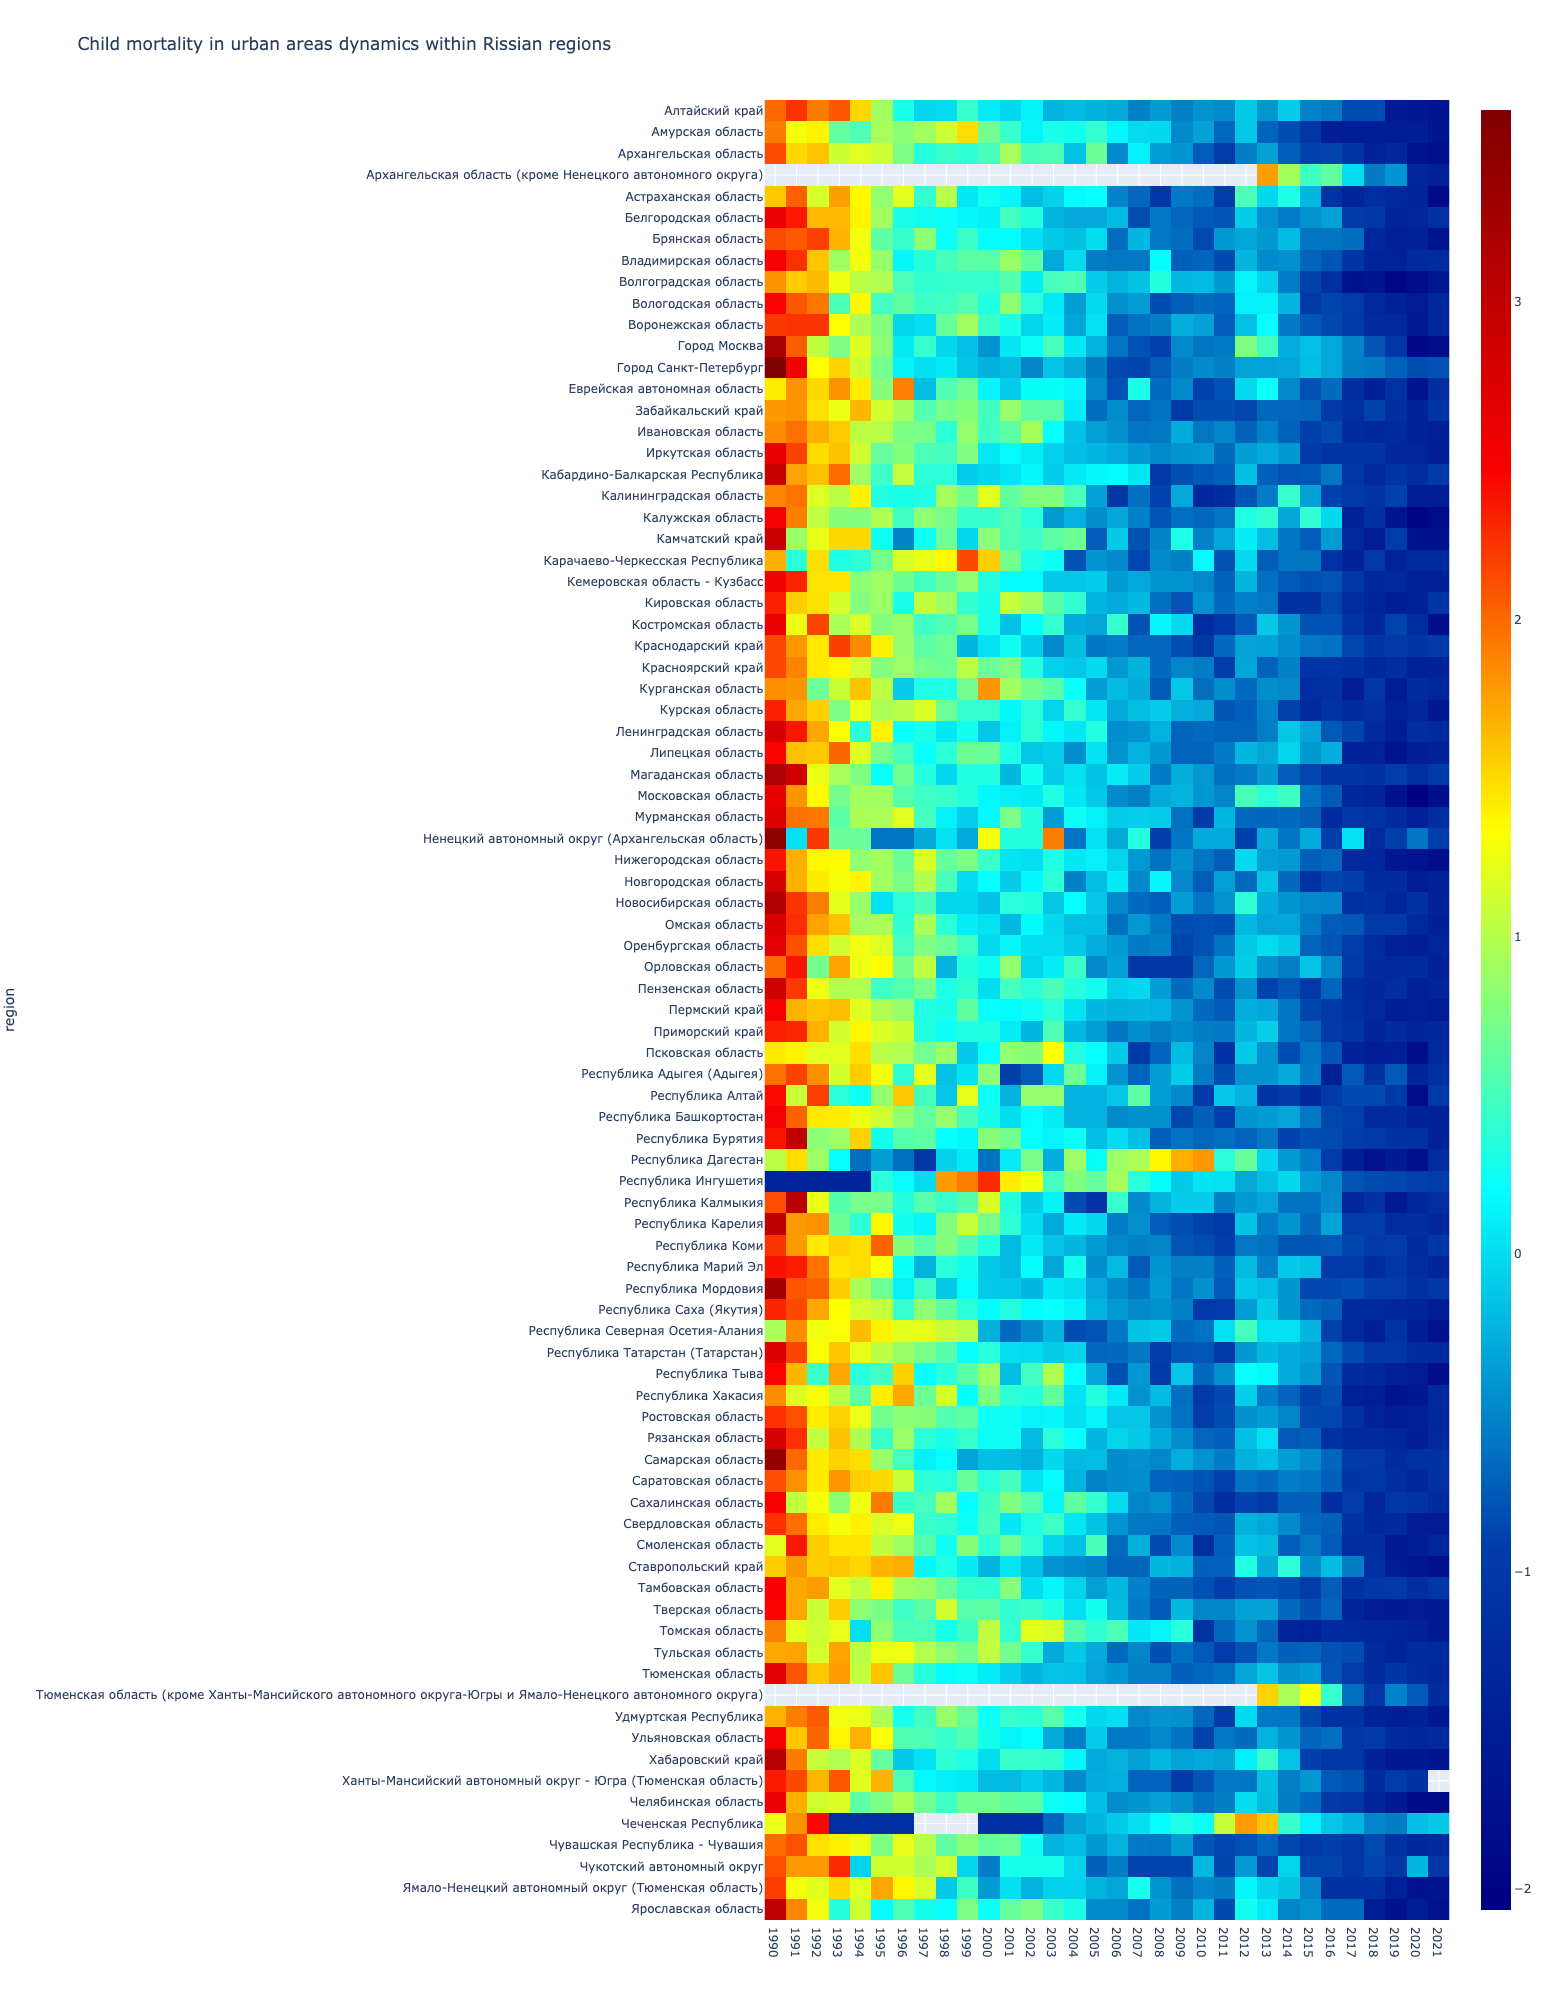

In [728]:
data_child_mortality_urban_normalized = normalize_data(data_child_mortality_urban)

fig = px.imshow(
    data_child_mortality_urban_normalized,
    height=2000,
    width=1550,
    color_continuous_scale='Jet',
    title='Child mortality in urban areas dynamics within Rissian regions'
)
fig.show('png')

Child mortality in urban areas has significantly decreased with the exception of the following regions:
- Город Санкт-Петербург
- Республика Ингушетия
- Чеченская Республика

If we connect the child mortality with the economic situation of the region, we cann assume that after applying the cluster algorithms these regions might be in the cluster of economically weaker regions. Which is definitely not the case for the city of Saint Petersburg.

### 2.4 Disability statistics

Data source is loaded and then gets transformed to contain the disability data per Russion region across the years 2017 and 2022 in absolute values. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `disability_{year}_total, disability_{year}_18_30, disability_{year}_31_40, disability_{year}_41_50, disability_{year}_60_` - columns containing the disability counts across the whole population and across different age groups for each of the regions in the corresponding year.

In [729]:
data_disability = pd.read_csv('data/disabled_total_by_age_2017_2022.csv', sep=';')
data_disability = data_disability[data_disability['date'].str.endswith('01-01')]


def flatten_table(df, years):
    result = []
    for year in years:
        df_year = df[df['date'].str.startswith(year)]
        df_year = df_year.drop(columns='date')
        df_year = rename_columns(df_year, f'disability_{year}_')
        df_year = df_year.set_index('region')
        result.append(df_year)
    return pd.concat(result, axis=1)


data_disability = flatten_table(data_disability, ['2017', '2018', '2019', '2020', '2021', '2022'])

Let's visualize the total dysability dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

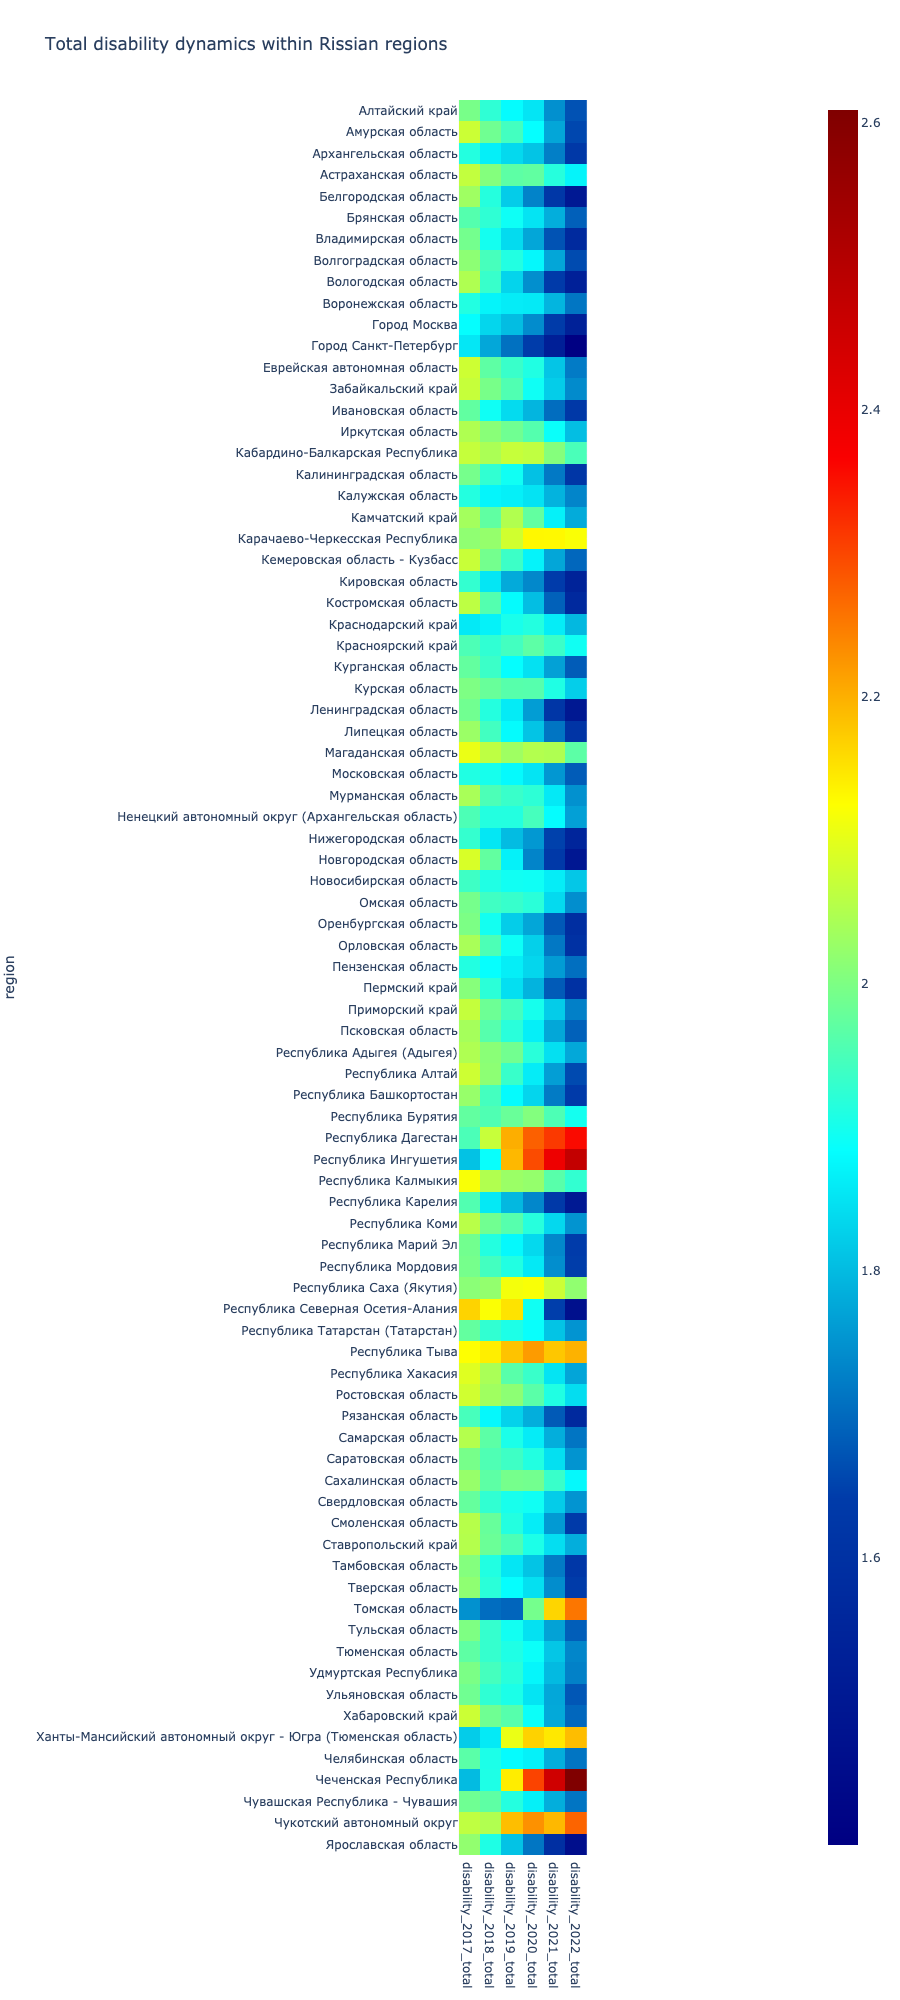

In [730]:
# Delete the years which have up to 40 % of empty values.
data_disability = drop_empty_years(data_disability)

data_disability_normalized = normalize_data(data_disability)

fig = px.imshow(
    data_disability_normalized.filter(regex='total$', axis=1),
    height=2000,
    width=900,
    color_continuous_scale='Jet',
    title='Total disability dynamics within Rissian regions'
)
fig.show('png')

Total disability has decreased with the exception of the following regions:
- Карачаево-Черкесская Республика
- Республика Дагестан
- Республика Ингушетия
- Республика Тыва
- Томская область
- Ханты-Мансийский автономный округ - Югра (Тюменская область)
- Чеченская Республика
- Чукотский автономный округ

Growing disability rate means that a portion of socially incecure population is growing in the region. Let's check after the applying the cluster algorithms if any of these regions will end-up in an economically weak cluster.

### 2.5 Desease Incidence Statistics

Data source is loaded and then gets transformed to contain the desease incidence (per 100000 people in the corresponding age group) data per Russion region across the years 2005 and 2016. Data has been reduced for total deseases per region and age group, specific desease statistics have been removed. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `desease_incidence_0-14 years_{year}, desease_incidence_15-17 years_{year}, desease_incidence_18 years and older_{year}, desease_incidence_Total_{year}` - columns containing the desease incidence across the whole population and across different age groups for each of the regions in the corresponding year.

In [731]:
data_desease_incidence = pd.read_excel(
    'data/morbidity_2005_2016_age_disease.xlsx',
    index_col=[0, 1]
)
data_desease_incidence_list = []
age_groups = ['0-14 years', '15-17 years', '18 years and older', 'Total']
for age_group in age_groups:
    df = data_desease_incidence[data_desease_incidence.index.get_level_values('age_group') == age_group]
    df = df.reset_index()
    df = df.drop('age_group', axis=1)
    df = rename_columns(df, f'desease_incidence_{age_group}_')
    df['region'] = df['region'].str.strip()
    df = df.set_index('region')
    data_desease_incidence_list.append(df)
data_desease_incidence = pd.concat(data_desease_incidence_list, axis=1)
data_desease_incidence = data_desease_incidence.sort_index()

Let's visualize the total desease incidence dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

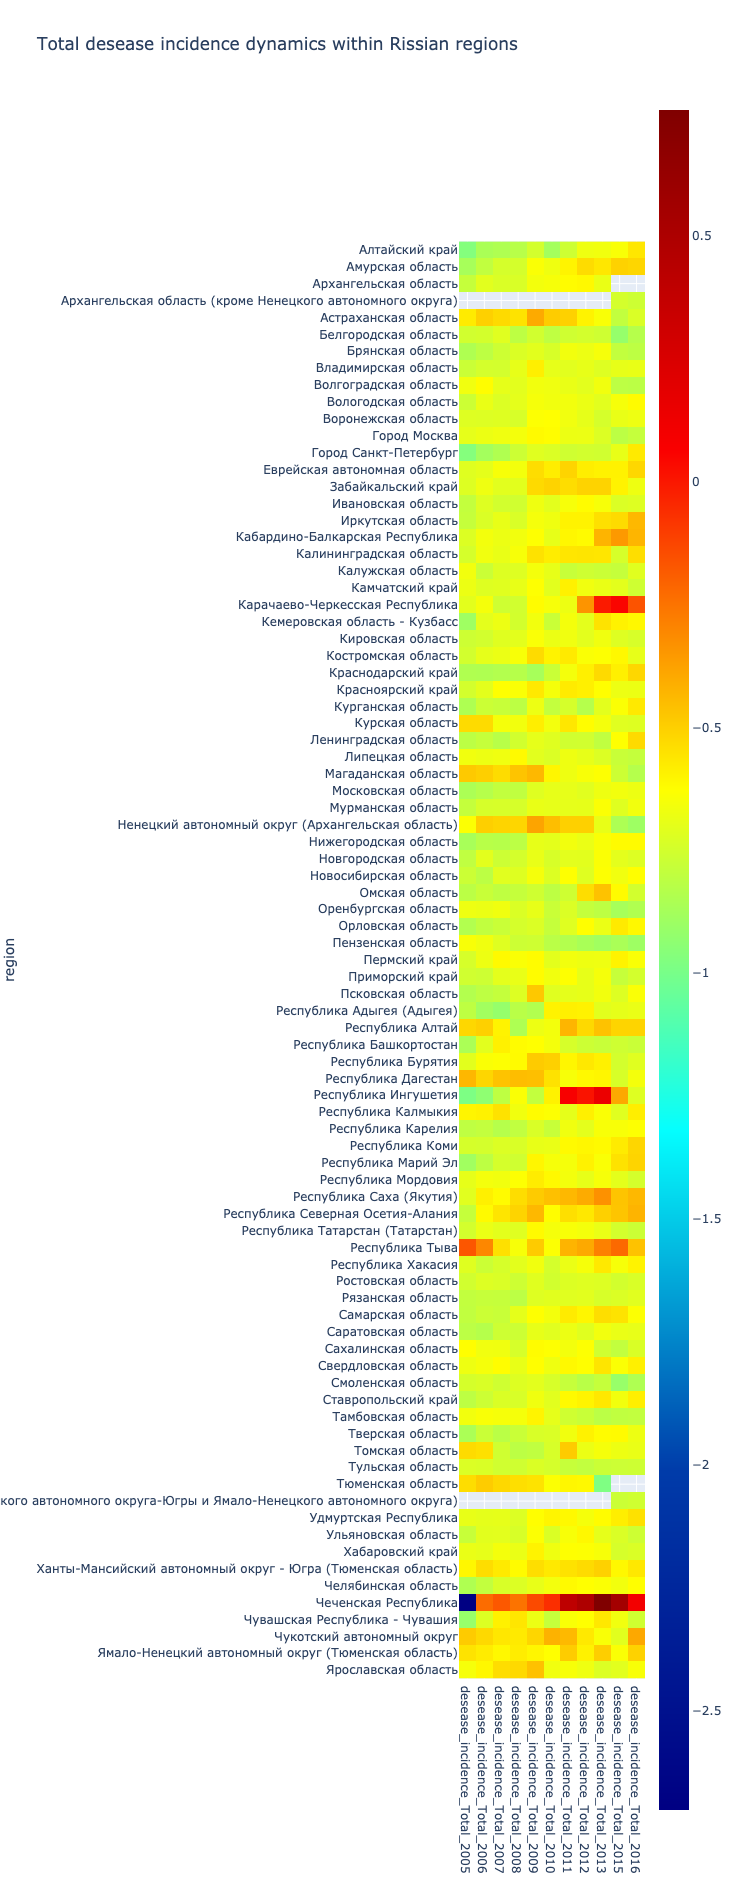

In [732]:
# Delete the years which have up to 40 % of empty values.
data_desease_incidence = drop_empty_years(data_desease_incidence)

data_desease_incidence_normalized = normalize_data(data_desease_incidence)

fig = px.imshow(
    data_desease_incidence_normalized.filter(like='Total', axis=1),
    height=1900,
    width=740,
    color_continuous_scale='Jet',
    title='Total desease incidence dynamics within Rissian regions'
)
fig.show('png')

Multiple regions show an increase in desease incidence with some regions showing significant growth:
- Карачаево-Черкесская Республика
- Республика Ингушетия
- Чеченская Республика

High desease incidence values could mean that a portion of socially incecure population is growing in the region. Let's check after the applying the cluster algorithms if any of these regions will end-up in an economically weak cluster.

### 2.6 Welfare Expense Share

Data source is loaded and then gets transformed to contain the welfare expense data per Russion region across the years 2015 and 2020. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `welfare_share_2015-welfare_share_2020` - columns containing the welfare expense percentage across the whole population for each of the regions in the corresponding year.

In [733]:
data_welfare_share = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')
data_welfare_share = data_welfare_share.set_index('region', drop=True)
data_welfare_share = data_welfare_share.sort_index()

Let's visualize the welfare expense share dynamics in different regions. We'll normalize data in each of the regions separately to get the dynamics within the region.

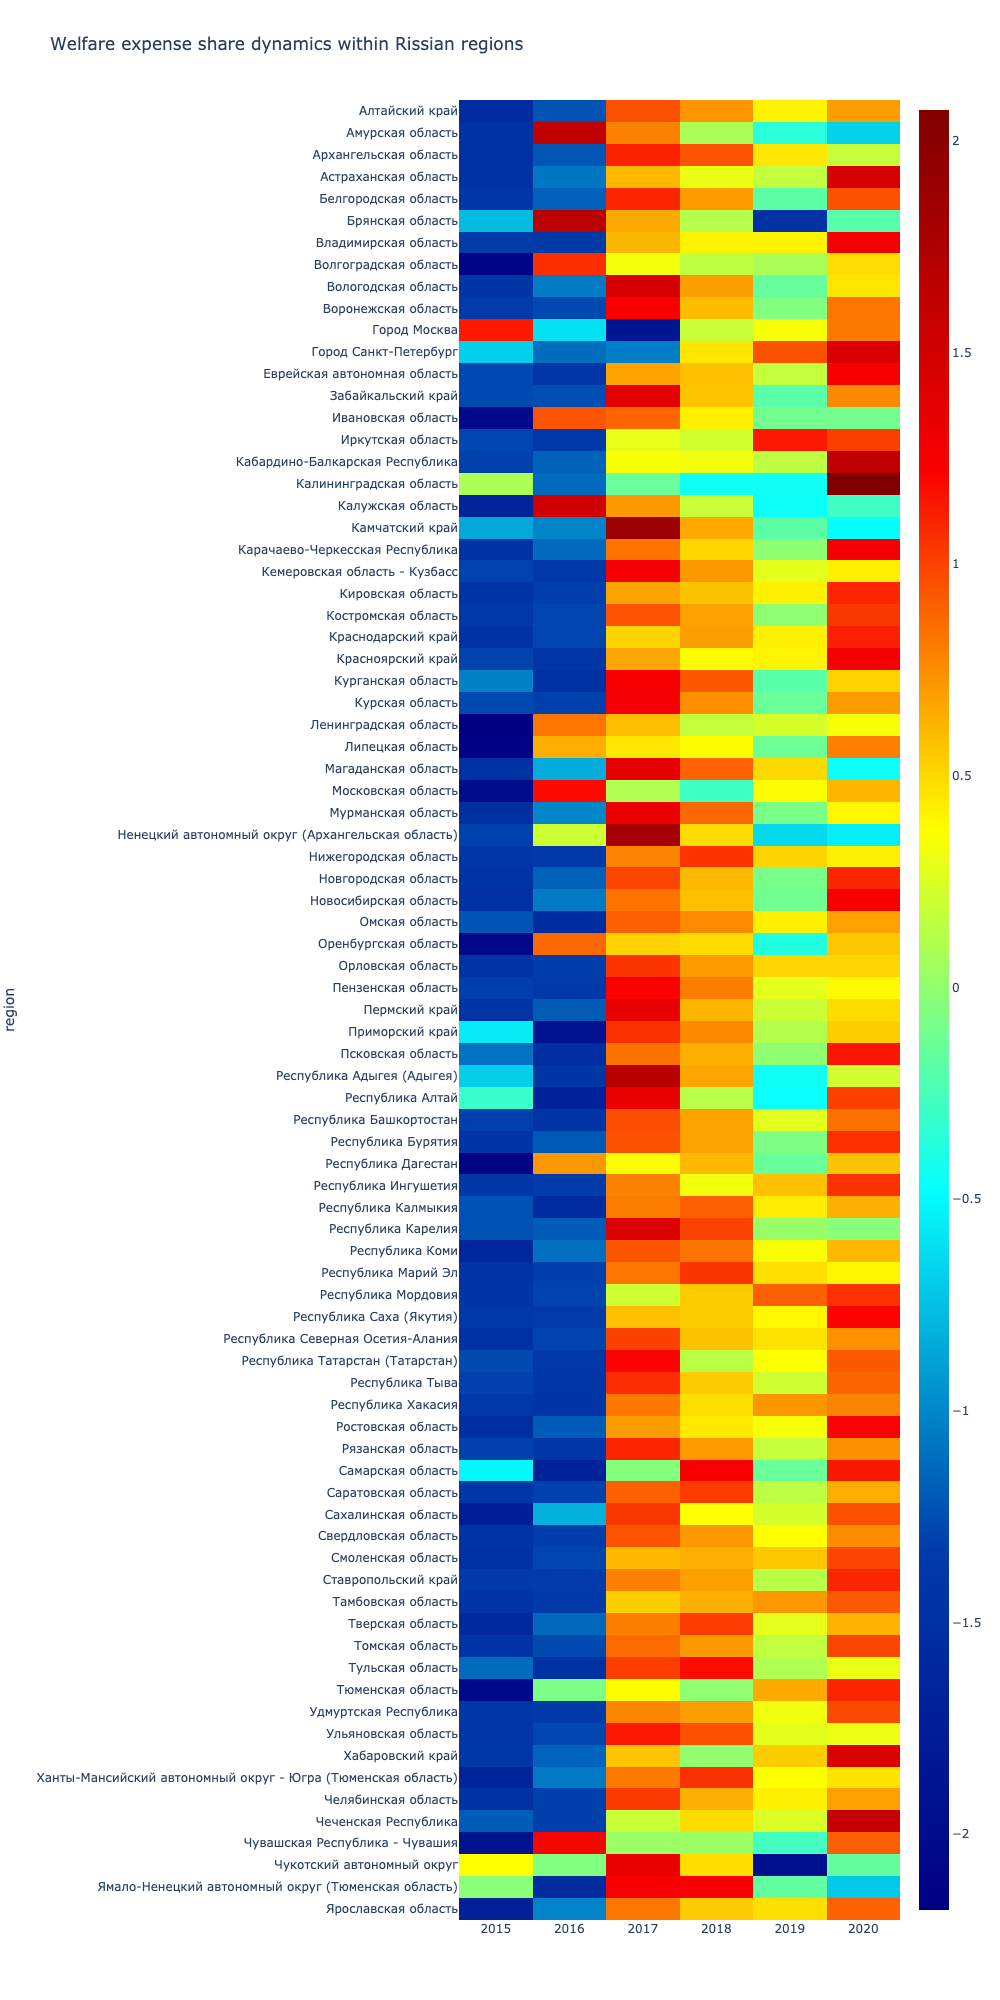

In [757]:
# Delete the years which have up to 40 % of empty values.
data_welfare_share = drop_empty_years(data_welfare_share)

data_welfare_share_normalized = normalize_data(data_welfare_share)

fig = px.imshow(
    data_welfare_share_normalized,
    height=2000,
    width=1000,
    color_continuous_scale='Jet',
    title='Welfare expense share dynamics within Rissian regions'
)
fig.show('png')

There is a trend of a significantly growing welfare expense share across the regions. Only the following regions do not follow this trend:
- Амурская область
- Камчатский край
- Магаданская область
- Ненецкий автономный округ (Архангельская область)
- Ямало-Ненецкий автономный округ (Тюменская область)

Growing welfare expense share might be interpreted as the region is economically strong to support poor people. If this share is not growing in a region, then it could be economically not doing well to an extent that there is no budget to support the socially weak groups of people. Let's see where the highlighted regions end-up after we apply the cluster algorithms.

### 2.7 Poverty Statistics

Data source is loaded and then gets transformed to contain the poverty data per Russion region across the years 1992 and 2020. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `poverty_1992-poverty_2020` - columns containing the poverty percentage across the whole population for each of the regions in the corresponding year.

In [735]:
data_poverty = pd.read_csv(
    'data/poverty_percent_by_regions_1992_2020.csv', 
    sep=';', 
    skipinitialspace=True
)


def flatten_table(df, years):
    result = []
    for year in years:
        df_year = df[df['year'] == year]
        df_year = df_year.drop(columns='year')
        df_year = rename_columns(df_year, f'poverty_{year}_')
        df_year = df_year.set_index('region')
        result.append(df_year)
    return pd.concat(result, axis=1)


data_poverty = flatten_table(data_poverty, list(range(1992, 2021)))
data_poverty = data_poverty.sort_index()

Poverty data is already provided as percentage. We will normalize this data by deviding it by 100.

In [736]:
# Delete the years which have up to 40 % of empty values.
data_poverty = drop_empty_years(data_poverty)

data_poverty = data_poverty / 100
data_poverty.head()

,poverty_1995_poverty_percent,poverty_1996_poverty_percent,poverty_1997_poverty_percent,poverty_1998_poverty_percent,poverty_1999_poverty_percent,poverty_2000_poverty_percent,poverty_2001_poverty_percent,poverty_2002_poverty_percent,poverty_2003_poverty_percent,poverty_2004_poverty_percent,...,poverty_2011_poverty_percent,poverty_2012_poverty_percent,poverty_2013_poverty_percent,poverty_2014_poverty_percent,poverty_2015_poverty_percent,poverty_2016_poverty_percent,poverty_2017_poverty_percent,poverty_2018_poverty_percent,poverty_2019_poverty_percent,poverty_2020_poverty_percent
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,0.337,0.468,0.457,0.529,0.538,0.539,0.473,0.389,0.339,0.309,...,0.226,0.206,0.176,0.171,0.180,0.178,0.175,0.174,0.176,0.175
Амурская область,0.361,0.282,0.263,0.312,0.380,0.477,0.453,0.446,0.356,0.338,...,0.204,0.160,0.162,0.148,0.152,0.170,0.167,0.156,0.157,0.152
Архангельская область,0.262,0.268,0.239,0.316,0.426,0.335,0.274,0.265,0.235,0.196,...,0.144,0.132,0.146,0.148,0.165,0.152,0.143,0.135,0.136,0.128
Архангельская область (кроме Ненецкого автономного округа),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.130,0.145,0.145,0.162,0.149,0.139,0.125,0.127,0.123
Астраханская область,0.323,0.307,0.250,0.304,0.360,0.334,0.311,0.262,0.229,0.203,...,0.142,0.125,0.118,0.120,0.142,0.161,0.155,0.151,0.155,0.156


### 2.8 Poverty Statisticts in Demografic Context

Data source is loaded and then gets transformed to contain the poverty data within demografic groups per Russion region across the years 2017 and 2020. Columns
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `poverty_dem_children_{year}, poverty_dem_seniors_{year}, poverty_dem_adults_{year}` - columns containing the poverty percentage across the demografic groups for each of the regions in the corresponding year.

In [737]:
data_poverty_dem_list = []
for year in range(2017, 2021):
    data_poverty_dem = pd.read_excel(f'data/poverty_socdem_{year}.xlsx')
    data_poverty_dem = rename_columns(data_poverty_dem, 'poverty_dem_')
    data_poverty_dem['region'] = data_poverty_dem['region'].str.strip()
    data_poverty_dem = data_poverty_dem.set_index('region', drop=True)
    data_poverty_dem_list.append(data_poverty_dem)
data_poverty_dem = pd.concat(data_poverty_dem_list, axis=1)

data_poverty_dem = data_poverty_dem.sort_index()

Poverty data in demographic context is already provided as percentage. We will normalize this data by deviding it by 100.

In [738]:
# Delete the years which have up to 40 % of empty values.
data_poverty_dem = drop_empty_years(data_poverty_dem)

data_poverty_dem = data_poverty_dem / 100
data_poverty_dem.head()

,poverty_dem_children_2017,poverty_dem_seniors_2017,poverty_dem_adults_2017,poverty_dem_children_2018,poverty_dem_seniors_2018,poverty_dem_adults_2018,poverty_dem_children_2019,poverty_dem_seniors_2019,poverty_dem_adults_2019,poverty_dem_children_2020,poverty_dem_seniors_2020,poverty_dem_adults_2020
region,,,,,,,,,,,,
Алтайский край,0.380,0.064,0.556,0.421,0.051,0.528,0.387,0.039,0.574,0.314,0.092,0.594
Амурская область,0.399,0.060,0.541,0.406,0.046,0.548,0.339,0.072,0.589,0.384,0.047,0.569
Архангельская область,0.381,0.068,0.551,0.395,0.065,0.540,0.330,0.081,0.590,0.302,0.067,0.631
Архангельская область (кроме Ненецкого автономного округа),0.374,0.071,0.555,0.388,0.066,0.546,0.313,0.089,0.598,0.285,0.072,0.643
Астраханская область,0.402,0.042,0.555,0.350,0.052,0.598,0.434,0.047,0.519,0.421,0.055,0.524


### 2.9 Housing Statistics 2020

#### 2.9.1 Living conditions - size

Data source contains the housing conditions in terms of the living space in the year 2020 across the Russian regions. Columns:
1. `housing_size_в том числе домохозяйства, указавшие, что при проживании не испытывают стесненностиgion` - percentage of the households which declared to have sufficient living space.
2. `housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность	housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают большую ` - percentage of the households which declared to have some shortage of the living space.
3. `housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность` - percentage of the households which declared to have a considerable shortage of the living space.
4. `housing_size_затруднились ответить` - percentage of the households which found it difficult to anser.
5. `housing_size_Размер общей площади в расчете на члена домохозяйства` - total area size per houshold member.
6. `housing_size_Размер жилой площади в расчете на члена домохозяйства` - living area size per household member.
7. `housing_size_Число жилых комнат в расчете на одно домохозяйство` - number of rooms per household.

In [739]:
data_housing_size = pd.read_excel(
    'data/housing_2020.xlsx', 
    sheet_name='housing_cond'
)
data_housing_size = rename_columns(data_housing_size, 'housing_size_')
data_housing_size = data_housing_size.set_index('region', drop=True)
data_housing_size = data_housing_size.sort_index()

Data for housing conditions in terms of living space is already provided as percentage. We will normalize this data by deviding it by 100.

In [740]:
# Delete the years which have up to 40 % of empty values.
data_housing_size = drop_empty_years(data_housing_size)

data_housing_size = data_housing_size / 100
data_housing_size.head()

,"housing_size_в том числе домохозяйства, указавшие, что при проживании не испытывают стесненности","housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают определенную стесненность","housing_size_в том числе домохозяйства, указавшие, что при проживании испытывают большую стесненность",housing_size_затруднились ответить,housing_size_Размер общей площади в расчете на члена домохозяйства,housing_size_Размер жилой площади в расчете на члена домохозяйства,housing_size_Число жилых комнат в расчете на одно домохозяйство
region,,,,,,,
Алтайский край,0.832,0.134,0.033,0.001,0.259,0.180,0.024
Амурская область,0.773,0.168,0.059,0.000,0.232,0.173,0.023
Архангельская область (кроме Ненецкого автономного округа),0.833,0.145,0.022,0.000,0.246,0.169,0.024
Астраханская область,0.775,0.194,0.031,0.000,0.249,0.192,0.023
Белгородская область,0.863,0.117,0.020,0.000,0.251,0.178,0.026


#### 2.9.2 Living conditions - state

Data source contains the housing conditions in terms of the state of the house in the year 2020 across the Russian regions. Columns:
1. `housing_state_из них домохозяйства, собирающиеся улучшить свои жилищные условия` - percentage of the households which declared to improve the house state.
2. `housing_state_из них указавшие: на стесненность проживания` - percentage of the households which declared to have not sufficient living space.
3. `housing_state_из них указавшие: на плохое или очень плохое состояние жилого помещения` - percentage of the households which declared to have very poor or poor state of the house.
4. `housing_state_из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания` - percentage of the households which declared to have very poor or poor state of the house and do not have sufficient living space.
5. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: планируют вселиться в жилое помещение, строительство которого ведут (участвуют в долевом строительстве)` - percentage of the households which declared to improve their living conditions by moving to an object which they are currently building.
6. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются подать документы для постановки на очередь (и/или ожидают прохождения очереди)	` - percentage of the households which declared to apply for a social appartment.
7. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: рассчитывают на получение нового жилья в связи со сносом дома` - percentage of the households which declared to expect to get a new apartment due to their current house demolition.
8. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются купить (построить) другое жилье` - percentage of the households which declared to improve their living conditions by buying a new apartment.
9. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются снимать жилье` - percentage of the households which declared to improve their living conditions by renting a different apartment.
10. `housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить свои жилищные условия другим способом` - percentage of the households which declared to improve their living conditions by some other means.
11. `housing_state_затруднились ответить` - percentage of the households which found it difficult to anser.
12. `housing_state_домохозяйства, не собирающиеся улучшать свои жилищные условия` - percentage of the households which do not plan to improve their living conditions.

In [741]:
data_housing_state = pd.read_excel(
    'data/housing_2020.xlsx', 
    sheet_name='housing_intent'
)
data_housing_state = rename_columns(data_housing_state, 'housing_state_')
data_housing_state = data_housing_state.set_index('region', drop=True)
data_housing_state = data_housing_state.sort_index()

Data for housing conditions in terms of state of the house is already provided as percentage. We will normalize this data by deviding it by 100.

In [742]:
# Delete the years which have up to 40 % of empty values.
data_housing_state = drop_empty_years(data_housing_state)

data_housing_state = data_housing_state / 100
data_housing_state.head()

,"housing_state_из них домохозяйства, собирающиеся улучшить свои жилищные условия",housing_state_из них указавшие: на стесненность проживания,housing_state_из них указавшие: на плохое или очень плохое состояние жилого помещения,housing_state_из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания,"housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: планируют вселиться в жилое помещение, строительство которого ведут (участвуют в долевом строительстве)","housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются подать документы для постановки на очередь (и/или ожидают прохождения очереди)","housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: рассчитывают на получение нового жилья в связи со сносом дома","housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются купить (построить) другое жилье","housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются снимать жилье","housing_state_из числа домохозяйств, собирающихся улучшить свои жилищные условия: собираются улучшить свои жилищные условия другим способом",housing_state_затруднились ответить,"housing_state_домохозяйства, не собирающиеся улучшать свои жилищные условия"
region,,,,,,,,,,,,
Алтайский край,0.149,0.063,0.003,0.002,0.031,0.050,0.008,0.315,0.039,0.562,0.006,0.851
Амурская область,0.147,0.061,0.013,0.003,0.166,0.055,0.018,0.326,0.071,0.351,0.013,0.846
Архангельская область (кроме Ненецкого автономного округа),0.134,0.059,0.014,0.007,0.157,0.034,0.063,0.327,0.046,0.373,0.000,0.866
Астраханская область,0.164,0.053,0.008,0.002,0.075,0.081,0.096,0.363,0.009,0.362,0.013,0.818
Белгородская область,0.120,0.042,0.007,0.004,0.112,0.016,0.016,0.295,0.000,0.569,0.000,0.880


### 2.10 Gross Regional Product statistics per capita

Data source contains per capita gross regional product in roubles per Russian region across the years 1996 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `gross_product_1996-gross_product_2020` - columns containing the per capita gross regional product in roubles for each of the regions in the corresponding year.

In [743]:
data_gross_product = pd.read_excel(
    'data/gross_regional_product_1996_2020.xlsx', 
    sheet_name='data'
)
data_gross_product['region'] = data_gross_product['region'].str.strip()
data_gross_product = rename_columns(data_gross_product, 'gross_product_')
data_gross_product = data_gross_product.set_index('region', drop=True)
data_gross_product = data_gross_product.sort_index()

Gross regional product data is already represented per capita, but the values are lagre compared to the normalized data of other features. I will the `MinMaxScaler` to normalize it.

In [744]:
# Delete the years which have up to 40 % of empty values.
data_gross_product = drop_empty_years(data_gross_product)

data_gross_product = normalize_data(data_gross_product)
data_gross_product.head()

,gross_product_1996,gross_product_1997,gross_product_1998,gross_product_1999,gross_product_2000,gross_product_2001,gross_product_2002,gross_product_2003,gross_product_2004,gross_product_2005,...,gross_product_2011,gross_product_2012,gross_product_2013,gross_product_2014,gross_product_2015,gross_product_2016,gross_product_2017,gross_product_2018,gross_product_2019,gross_product_2020
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,-1.177392,-1.179318,-1.172910,-1.126702,-1.066570,-1.002109,-0.952707,-0.883219,-0.765956,-0.668110,...,0.256234,0.431256,0.653972,0.797643,0.997518,1.213466,1.287782,1.467778,1.729221,1.947863
Амурская область,-1.120475,-1.104165,-1.108541,-1.066687,-1.027590,-0.940222,-0.891999,-0.836674,-0.754233,-0.658294,...,0.472502,0.514455,0.384534,0.552798,0.902633,1.066860,1.089789,1.371419,1.991130,2.299298
Архангельская область,-1.127728,-1.120088,-1.113616,-1.074245,-0.997739,-0.979079,-0.929143,-0.863238,-0.741390,-0.661911,...,0.260574,0.384185,0.490438,0.646883,0.948317,1.255347,1.434038,1.828299,1.938191,1.607120
Архангельская область (кроме Ненецкого автономного округа),NaN,NaN,-0.827806,-0.827806,-0.827806,-0.827806,-0.827806,-0.827806,-0.827806,-0.827806,...,0.334207,0.524704,0.587675,0.725358,0.935335,1.174827,1.380689,1.636755,1.720265,1.741669
Астраханская область,-0.985789,-0.980752,-0.971880,-0.940892,-0.874820,-0.851594,-0.803460,-0.750651,-0.717801,-0.643773,...,-0.089843,0.109152,0.456529,0.572059,0.710553,0.962006,1.363582,2.109035,2.253069,1.871074


### 2.11 Regional production statistics

Data source contains Russian regions's total production in roubles per across the years 1996 and 2020. Data from different industries has been aggregated to form a single total value. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `production_2005-production_2020` - columns containing the regions' total production in roubles for each of the regions in the corresponding year.

In [745]:
data_production = pd.read_excel('data/regional_production_2005_2016.xlsx', header=1)
data_production['region'] = data_production['region'].str.strip()
#data_production = rename_columns(data_production, 'production_')
data_production = data_production.groupby('region').sum()

data_production_2 = pd.read_excel('data/regional_production_2017_2020.xlsx', header=1)
data_production_2['region'] = data_production_2['region'].str.strip()
#data_production_2 = rename_columns(data_production_2, 'production_')
data_production_2 = data_production_2.groupby('region').sum()

data_production = pd.concat([data_production, data_production_2], axis=1)
data_production = data_production.sort_index()
data_production.columns = data_production.columns.map(str)

In [746]:
data_production = data_production / data_population / 1000

# Delete the years which have up to 40 % of empty values.
data_production = drop_empty_years(data_production)
data_production = rename_columns(data_production, 'production_', 0)
data_production.head()

,production_2005,production_2006,production_2007,production_2008,production_2009,production_2010,production_2011,production_2012,production_2013,production_2014,production_2015,production_2016,production_2017,production_2018,production_2019,production_2020
region,,,,,,,,,,,,,,,,
Алтайский край,0.036472,0.046529,0.052683,0.074041,0.060738,0.084314,0.094033,0.099942,0.103145,0.106389,0.134823,0.132862,0.311106,0.328156,0.359359,0.367884
Амурская область,0.036401,0.041648,0.045562,0.055429,0.072558,0.086360,0.116684,0.124654,0.121490,0.134841,0.171141,0.156309,0.335321,0.336614,0.428680,0.512094
Архангельская область,0.094268,0.102502,0.130650,0.157944,0.183674,0.228545,0.250583,0.272257,0.402087,0.322403,0.375493,0.393828,1.111915,1.166748,1.105317,1.047058
Архангельская область (кроме Ненецкого автономного округа),0.000000,0.000000,0.000000,0.000000,0.000000,0.105752,0.112463,0.128381,0.257012,0.163532,0.185538,0.179691,0.632021,0.545863,0.484949,0.607921
Астраханская область,0.040659,0.045452,0.051881,0.084196,0.062350,0.075840,0.094795,0.123506,0.160097,0.170201,0.207216,0.223633,0.614968,0.868555,0.889011,0.720432


### 2.12 Retail turnover statistics

Data source contains per capita yearly retail turnover in roubles per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `retail_turnover_2000-retail_turnover_2021` - columns containing the per capita yearly retail turnover in roubles for each of the regions in the corresponding year.

In [747]:
data_retail_turnover = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xlsx')
data_retail_turnover['region'] = data_retail_turnover['region'].str.strip()
#data_retail_turnover = rename_columns(data_retail_turnover, 'retail_turnover_')
data_retail_turnover = data_retail_turnover.set_index('region')
data_retail_turnover = data_retail_turnover.sort_index()
data_retail_turnover.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,9221,12280,15839,20534,25927,32543,42444,53937,70308,65303,...,105754,118096,128376,134925,137844,143873,150444,159514,153605,174321
Амурская область,12303,14786,17229,20378,26781,32829,40948,49413,64081,71086,...,127200,145301,163781,182491,191523,202038,214688,231113,245233,276635
Архангельская область,11845,17821,21924,26959,33554,41707,50781,61423,79990,87768,...,135625,154320,176491,194266,203019,217241,229576,239516,249101,278284
Архангельская область (кроме Ненецкого автономного округа),0,0,0,0,0,0,0,0,0,0,...,0,154177,176420,194345,202977,217332,229922,240155,250033,280050
Астраханская область,10876,14265,17668,21623,25775,32717,42007,55755,77056,83032,...,131101,147954,162393,170883,164241,163829,170710,179153,174527,196096


In [748]:
data_retail_turnover / data_population

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,NaN,0.003477,0.004650,0.006043,0.007890,0.010081,0.012815,0.016954,0.021810,0.028657,...,0.049232,0.053699,0.056577,0.057996,0.060817,0.064017,0.068378,0.066290,0.075912,NaN
Амурская область,NaN,0.013150,0.016019,0.018904,0.022616,0.030166,0.037561,0.047556,0.058099,0.075899,...,0.177867,0.201881,0.225333,0.237713,0.251996,0.268890,0.291370,0.310404,0.353823,NaN
Архангельская область,NaN,0.008520,0.013016,0.016235,0.020230,0.025506,0.032102,0.039616,0.048492,0.063627,...,0.128355,0.148090,0.164170,0.172918,0.186353,0.198762,0.209345,0.219176,0.246913,NaN
Архангельская область (кроме Ненецкого автономного округа),NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.132968,0.153574,0.170486,0.179588,0.193733,0.206945,0.218265,0.228879,0.258668,NaN
Астраханская область,NaN,0.010743,0.014134,0.017571,0.021520,0.025619,0.032507,0.041902,0.055683,0.076604,...,0.145934,0.159754,0.167321,0.161238,0.160795,0.167772,0.176668,0.173524,0.196533,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Чеченская Республика,NaN,0.000000,0.000000,0.000000,0.000000,0.007231,0.009038,0.007764,0.011321,0.020248,...,0.058190,0.065588,0.077456,0.077848,0.078505,0.080572,0.082404,0.083826,0.094326,NaN
Чувашская Республика - Чувашия,NaN,0.005585,0.007590,0.009084,0.011437,0.014108,0.017967,0.022844,0.030111,0.042537,...,0.077636,0.085843,0.089259,0.089723,0.093272,0.101111,0.111404,0.116244,0.137556,NaN
Чукотский автономный округ,NaN,0.222729,0.384677,0.596268,0.719894,0.791616,0.799093,0.861446,0.983312,1.548661,...,2.131115,2.033330,2.361199,3.070738,3.688752,3.918923,4.225258,4.316915,4.556525,NaN


### 2.13 Income situation

#### 2.13.1 Per capita monthly cash income

Data source contains per capita monthly income in roubles per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `monthly_income_2015-monthly_income_2020` - columns containing the per capita monthly cash income in roubles for each of the regions in the corresponding year.

In [749]:
data_monthly_cash_income = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='per_capita_cash_income'
)
data_monthly_cash_income = rename_columns(data_monthly_cash_income, 'monthly_income_')
data_monthly_cash_income = data_monthly_cash_income.set_index('region', drop=True)
data_monthly_cash_income = data_monthly_cash_income.sort_index()
data_monthly_cash_income.head()

,monthly_income_2015,monthly_income_2016,monthly_income_2017,monthly_income_2018,monthly_income_2019,monthly_income_2020
region,,,,,,
Алтайский край,20860,21256,22139,22829,23937,23864
Амурская область,28240,27976,29213,30937,33304,35499
Архангельская область,31285,31394,32310,33831,35693,36779
Архангельская область (кроме Ненецкого автономного округа),29716,29837,30707,32054,33874,34852
Астраханская область,23832,22841,22884,23670,24971,25199


#### 2.13.2 Real cash income

Data source contains real cash income in percent compared to the previous year per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `real_income_2015-real_income_2020` - columns containing the real cash income in percent compared to the previous year for each of the regions in the corresponding year.

In [750]:
data_real_cash_income = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='real_incomes'
)
data_real_cash_income = rename_columns(data_real_cash_income, 'real_income_')
data_real_cash_income = data_real_cash_income.set_index('region', drop=True)
data_real_cash_income = data_real_cash_income.sort_index()
data_real_cash_income.head()

,real_income_2015,real_income_2016,real_income_2017,real_income_2018,real_income_2019,real_income_2020
region,,,,,,
Алтайский край,99.1,94.7,100.0,99.7,99.6,95.5
Амурская область,96.1,92.1,101.1,102.4,101.7,100.3
Архангельская область,95.1,92.9,98.9,102.0,100.1,98.6
Архангельская область (кроме Ненецкого автономного округа),95.1,93.0,98.7,101.7,100.2,98.4
Астраханская область,94.0,90.1,97.1,100.6,100.7,97.1


#### 2.13.3 Per capita monthly formal wage

Data source contains per capita monthly formal wage in roubles per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `monthly_wage_2015-monthly_wage_2020` - columns containing per capita monthly formal wage in roubles for each of the regions in the corresponding year.

In [751]:
data_monthly_formal_wage = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='formal_wage_paid'
)
data_monthly_formal_wage = rename_columns(data_monthly_formal_wage, 'monthly_wage_')
data_monthly_formal_wage = data_monthly_formal_wage.set_index('region', drop=True)
data_monthly_formal_wage = data_monthly_formal_wage.sort_index()
data_monthly_formal_wage.head()

,monthly_wage_2015,monthly_wage_2016,monthly_wage_2017,monthly_wage_2018,monthly_wage_2019,monthly_wage_2020
region,,,,,,
Алтайский край,20090,21202,22743,25519,27962,30072
Амурская область,32902,33837,37368,42315,47234,52430
Архангельская область,38300,40790,42950,48307,52434,55891
Архангельская область (кроме Ненецкого автономного округа),35592,38118,40352,45427,49435,52779
Астраханская область,25499,27493,29599,33630,36093,38885


#### 2.13.4 Real wage

Data source contains real wage in percent compared to the previous year per Russian region across the years 2015 and 2020. Columns:
1. `region` - name of the region of the Russian Federation. Data for districts uniting multiple regions has been removed.
2. `real_wage_2015-real_wage_2020` - columns containing the real wage in percent compared to the previous year for each of the regions in the corresponding year.

In [752]:
data_real_wage = pd.read_excel(
    'data/cash_real_income_wages_2015_2020.xlsx', 
    sheet_name='real_pay'
)
data_real_wage = rename_columns(data_real_wage, 'real_wage_')
data_real_wage = data_real_wage.set_index('region', drop=True)
data_real_wage = data_real_wage.sort_index()
data_real_wage.head()

,real_wage_2015,real_wage_2016,real_wage_2017,real_wage_2018,real_wage_2019,real_wage_2020
region,,,,,,
Алтайский край,90.0,98.4,103.6,109.3,104.9,103.8
Амурская область,88.0,96.0,107.4,110.1,106.0,105.2
Архангельская область,92.7,99.4,102.0,110.6,103.8,102.8
Архангельская область (кроме Ненецкого автономного округа),92.4,100.0,102.5,110.7,104.0,102.9
Астраханская область,89.9,101.4,104.5,110.7,103.0,104.5


In [753]:
data_population_normalized = rename_columns(
    data_population_normalized, 
    'population_', 
    start_col=0
)
data_child_mortality_rural_normalized = rename_columns(
    data_child_mortality_rural_normalized, 
    'child_mortality_rural_', 
    start_col=0
)
data_child_mortality_urban_normalized = rename_columns(
    data_child_mortality_urban_normalized, 
    'child_mortality_urban_', 
    start_col=0
)
data_welfare_share_normalized = rename_columns(
    data_welfare_share_normalized, 
    'welfare_share_',
    start_col=0
)
data_welfare_share_normalized


,welfare_share_2015,welfare_share_2016,welfare_share_2017,welfare_share_2018,welfare_share_2019,welfare_share_2020
region,,,,,,
Алтайский край,-1.555940,-1.224742,0.948744,0.721046,0.410547,0.700346
Амурская область,-1.470640,1.619297,0.791066,0.090256,-0.355714,-0.674264
Архангельская область,-1.466304,-1.219636,1.110006,0.945560,0.452225,0.178149
Астраханская область,-1.474853,-1.076877,0.608670,0.304335,0.163873,1.474853
Белгородская область,-1.411925,-1.165659,1.099988,0.705962,-0.180595,0.952228
...,...,...,...,...,...,...
Чеченская Республика,-1.189603,-1.312313,0.180656,0.487430,0.242011,1.591818
Чувашская Республика - Чувашия,-1.907319,1.210292,0.031683,0.031683,-0.272474,0.906135
Чукотский автономный округ,0.371173,-0.053025,1.325618,0.477223,-1.961915,-0.159074
